## Training

Using this notebook, we train on a subset of classes (phenotypes). For example, we leave out the mitochondrial phenotype.

**Naming the experiment**

In [1]:
run_desc = 'chong_no_batch_no_mitochondria_and_no_endosome'#change here for exp id with directories
del_id=list((5,8))

### Getting the data

Downloading the data if not present

In [2]:
#Taken from https://github.com/okraus/DeepLoc/blob/master/download_datasets.sh
import os
if not (os.path.exists('datasets/Chong_train_set.hdf5')):
    !curl http://spidey.ccbr.utoronto.ca/~okraus/DeepLoc_full_datasets.zip --output DeepLoc_full_datasets.zip
    !unzip DeepLoc_full_datasets.zip
    !rm DeepLoc_full_datasets.zip
!ls -lh datasets

total 3.2G
-rw-r--r-- 1 root root 153M Jan  7  2017 Chong_test_set.hdf5
-rw-r--r-- 1 root root  800 Jul 10 07:49 Chong_test_set.hdf5.hdf5
-rw-r--r-- 1 root root 738M Jan  7  2017 Chong_train_set.hdf5
-rw-r--r-- 1 root root 152M Jan  7  2017 Chong_valid_set.hdf5
-rw-r--r-- 1 root root  740 Jan  8  2017 README.TXT
-rw-r--r-- 1 root root  46M Jan  8  2017 Schuldiner_test_set.hdf5
-rw-r--r-- 1 root root 405M Jan  8  2017 Schuldiner_train_set.hdf5
-rw-r--r-- 1 root root 172M Jan  8  2017 wt2017_test_set.hdf5
-rw-r--r-- 1 root root 1.5G Jan  8  2017 wt2017_train_set.hdf5


In [3]:
!nvidia-smi

Tue Jul 17 16:02:27 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.30                 Driver Version: 390.30                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P40           Off  | 00000000:89:00.0 Off |                    0 |
| N/A   27C    P0    47W / 250W |      0MiB / 22919MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
import tensorflow as tf
import keras


from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Flatten, Activation
from keras.layers import Lambda, Dropout, BatchNormalization, Convolution2D, MaxPooling2D
from keras import initializers
from keras.optimizers import Adam, RMSprop
from keras.utils import to_categorical
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras import backend as K
from keras.applications.vgg16 import VGG16, preprocess_input

from keras.preprocessing.image import ImageDataGenerator

import h5py
import numpy as np
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import time
%matplotlib inline
tf.__version__,keras.__version__, np.__version__, h5py.__version__

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


('1.6.0', '2.1.5', '1.14.1', '2.7.1')

## Data Loading

In [5]:
fn1 = 'datasets/Chong_train_set.hdf5'
d1 = h5py.File(fn1)
print(list(d1.keys()))
l = [d for d in zip(np.argmax(d1['Index1'],axis=1), d1['label_names'])]
from collections import Counter
Counter(l)

['Index1', 'Info1', 'data1', 'label_names']


Counter({(0, b'ACTIN'): 738,
         (1, b'BUDNECK'): 535,
         (2, b'BUDTIP'): 336,
         (3, b'CELLPERIPHERY'): 423,
         (4, b'CYTOPLASM'): 1500,
         (5, b'ENDOSOME'): 1500,
         (6, b'ER'): 1500,
         (7, b'GOLGI'): 1500,
         (8, b'MITOCHONDRIA'): 1500,
         (9, b'NUCLEARPERIPHERY'): 1500,
         (10, b'NUCLEI'): 1500,
         (11, b'NUCLEOLUS'): 1500,
         (12, b'PEROXISOME'): 988,
         (13, b'SPINDLE'): 185,
         (14, b'SPINDLEPOLE'): 1500,
         (15, b'VACUOLARMEMBRANE'): 1500,
         (16, b'VACUOLE'): 1500,
         (17, b'DEAD'): 749,
         (18, b'GHOST'): 1428})

In [6]:
def flatBatch2Tensor(batchData,imSize,channels):
    splitByChannel = [batchData[:,(chan*imSize**2):((chan+1)*imSize**2)].reshape((-1,imSize,imSize,1)) \
                      for chan in range(channels)]
    tensorBatchData = np.concatenate(splitByChannel,3)
    return tensorBatchData

def load_kraus():
       
    #fn1 = 'datasets/wt2017_train_set.hdf5'
    #fn2 = 'datasets/wt2017_test_set.hdf5'
    
    fn1 = 'datasets/Chong_train_set.hdf5'
    fn2 = 'datasets/Chong_test_set.hdf5'
    fn3 = 'datasets/Chong_valid_set.hdf5'
    d1 = h5py.File(fn1)
    d2 = h5py.File(fn2)
    d3 = h5py.File(fn3)
    
    X_train = flatBatch2Tensor(d1['data1'][:], 64, 2)
    X_test = flatBatch2Tensor(d2['data1'][:], 64, 2)
    X_valid = flatBatch2Tensor(d3['data1'][:], 64, 2)
    y_train = d1['Index1'][:]
    y_test = d2['Index1'][:]
    y_valid = d3['Index1'][:]
    
    # We bring the data into the range [0,1] and clamp it due to heavy outliers
    X_train = np.clip(X_train,0,100)/100
    X_test = np.clip(X_test,0,100)/100
    X_valid = np.clip(X_valid,0,100)/100
    
    # For sparse labels
    #y_train = np.ndarray.astype(np.argmax(d1['Index1'],axis=1),'int32')
    #y_test = np.ndarray.astype(np.argmax(d2['Index1'],axis=1),'int32')
        
    print("X_train type {} dtype {} shape {}".format(type(X_train), X_train.dtype,np.shape(X_train)))
    print("X_train min {}, max {} mean {}".format(np.min(X_train), np.max(X_train), np.mean(X_train)))
    print("Y_train shape {} Y_test shape{} Y_validation shape{} ".format(np.shape(y_train), np.shape(y_test), np.shape(y_valid)))
    return X_train, y_train, X_test, y_test, X_valid, y_valid

In [7]:
import h5py
import numpy as np
X_train, Y_train, X_test, Y_test, X_valid, Y_valid = load_kraus()

X_train type <class 'numpy.ndarray'> dtype float32 shape (21882, 64, 64, 2)
X_train min 0.0, max 1.0 mean 0.17277522385120392
Y_train shape (21882, 19) Y_test shape(4516, 19) Y_validation shape(4491, 19) 


In [8]:
np.max(np.argmax(Y_train, axis=1)) + 1, Y_valid.shape #19 number of classes - 1

(19, (4491, 19))

### Removing cells in the training and validation set

We remove the e.g. mitochondrial cells from the training and validation set.

In [9]:
y_train = np.argmax(Y_train,axis=1)
y_valid = np.argmax(Y_valid,axis=1)
y_test = np.argmax(Y_test,axis=1)

y_max = np.max(y_train) #0,...
num_class_org = y_max + 1
print('Number of classes (original)', num_class_org, '   from', 0, 'to', y_max)

Number of classes (original) 19    from 0 to 18


We build a list of classes which shall be used in the training.

In [10]:
idx = del_id# here class index to delete
idx

[5, 8]

In [11]:
## For myto
if True:
    idx = del_id# here class index to delete
    keep_idx = list(np.linspace(start=0,stop=y_max,num=y_max+1, dtype='int32'))
    keep_idx = list(np.delete(keep_idx,idx))

In [12]:
keep_idx

[0, 1, 2, 3, 4, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [13]:
num_classes = len(keep_idx)
print("Number of classes (after cutting)" , num_classes, "to keep from org", keep_idx)

all_to_limited = dict()
limited_to_all = dict()
c = 0
for i in range(num_class_org):
    all_to_limited[i] = c
    limited_to_all[c] = i
    if (keep_idx.count(i) > 0):
        c += 1


Number of classes (after cutting) 17 to keep from org [0, 1, 2, 3, 4, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


In [14]:
keep_training = [keep_idx.count(y) > 0 for y in y_train]
X_train_keep = X_train[keep_training]
y_train_keep = [all_to_limited[y] for y in y_train if keep_idx.count(y) > 0] 

keep_valid = [keep_idx.count(y) > 0 for y in y_valid]
X_valid_keep = X_valid[keep_valid]
y_valid_keep = [all_to_limited[y] for y in y_valid if keep_idx.count(y) > 0] 

X_train_keep.shape, X_valid_keep.shape, len(np.unique(y_train_keep)), len(np.unique(y_valid_keep))  

((18882, 64, 64, 2), (3629, 64, 64, 2), 17, 17)

In [15]:
print(len(Y_train) - (np.sum(np.argmax(Y_train,axis=1)==del_id[0])+np.sum(np.argmax(Y_train,axis=1)==del_id[1])))
print(len(Y_valid) - (np.sum(np.argmax(Y_valid,axis=1)==del_id[0])+np.sum(np.argmax(Y_valid,axis=1)==del_id[1])))

18882
3629


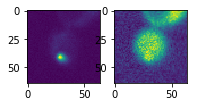

In [16]:
plt.subplot(1,4,1)
plt.imshow(X_train_keep[len(X_train_keep)-1,:,:,0])
plt.subplot(1,4,2)
plt.imshow(X_train_keep[len(X_train_keep)-1,:,:,1])

## Building of Model and Training

In [17]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    #zoom_range=[0.1,0.1]
)

In [18]:
# Helper functions
def one_hot(Y, num_cl):
    d = np.zeros((len(Y),num_cl), dtype='int8')
    for row,col in enumerate(Y):
        d[row, col] = 1
    return d
one_hot(np.array((1,0,1,1,2)), 3).shape

(5, 3)

In [19]:
batch_size = 128
train_generator = datagen.flow(
        x = X_train_keep,
        y = one_hot(y_train_keep, num_classes),
        batch_size = batch_size,
        shuffle = True)

/usr/local/lib/python3.5/dist-packages/keras/preprocessing/image.py:935: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (18882, 64, 64, 2) (2 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


In [20]:
tf.reset_default_graph()
model = Sequential()

model.add(Convolution2D(32, (3,3),kernel_initializer='he_normal',padding='same',input_shape=(64,64,2)))
#model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dropout(0.3))
model.add(Convolution2D(32, (3,3),kernel_initializer='he_normal',padding='same'))
#model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Convolution2D(64, (3,3),kernel_initializer='he_normal',padding='same'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Convolution2D(64, (3,3),kernel_initializer='he_normal',padding='same'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())#macht einen vektor aus dem output
model.add(Dropout(0.3))            
model.add(Dense(200,kernel_initializer='he_normal'))
#model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dropout(0.3))
model.add(Dense(num_classes,kernel_initializer='he_normal'))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [21]:
print(model.summary())
model.input_shape, model.output_shape

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        608       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 32)        0         
__________

((None, 64, 64, 2), (None, 17))

In [22]:
import glob
import os
def create_result_subdir(result_dir, run_desc):
    ordinal = 0
    for fname in glob.glob(os.path.join(result_dir, '*')):
        try:
            fbase = os.path.basename(fname)
            ford = int(fbase[:fbase.find('-')])
            ordinal = max(ordinal, ford + 1)
        except ValueError:
            pass

    result_subdir = os.path.join(result_dir, '%03d-%s' % (ordinal, run_desc))
    if os.path.isdir(result_subdir):
        return create_result_subdir(result_dir, run_desc) # Retry.
    if not os.path.isdir(result_subdir):
        os.makedirs(result_subdir)
    return result_subdir, ordinal

In [23]:
resdir, ordinal = create_result_subdir('results_bayes', run_desc)

In [24]:
resdir

'results_bayes/022-chong_no_batch_no_mitochondria_and_no_endosome'

In [25]:
tb_cb = keras.callbacks.TensorBoard(log_dir=resdir, histogram_freq=0, write_graph=True)

In [26]:
checkpointer = keras.callbacks.ModelCheckpoint( 
    filepath =  resdir+"/weights_Chong_data_epoch_{epoch:03d}-{val_loss:.2f}.hdf5",
    verbose = 1, 
    save_best_only = False,
    period = 25 )

In [27]:
one_hot(y_valid_keep, num_classes).shape, num_classes, num_class_org,one_hot(y_train_keep, num_classes).shape

((3629, 17), 17, 19, (18882, 17))

In [28]:
history = model.fit_generator(
                    train_generator,
                    steps_per_epoch = X_train_keep.shape[0]/batch_size,
                    epochs = 500,                    
                    validation_data = (X_valid_keep, one_hot(y_valid_keep, num_classes)),
                    verbose = 1,
                    callbacks=[checkpointer, tb_cb]
)
model.save(resdir+"/final.keras.model")

Epoch 1/500
148/147 [==============================] - 17s 118ms/step - loss: 2.3270 - acc: 0.2493 - val_loss: 1.9675 - val_acc: 0.3613
Epoch 2/500
148/147 [==============================] - 17s 115ms/step - loss: 1.6877 - acc: 0.4337 - val_loss: 1.5154 - val_acc: 0.5249
Epoch 3/500
148/147 [==============================] - 17s 116ms/step - loss: 1.4088 - acc: 0.5213 - val_loss: 1.2817 - val_acc: 0.5834
Epoch 4/500
148/147 [==============================] - 17s 116ms/step - loss: 1.2344 - acc: 0.5738 - val_loss: 1.0805 - val_acc: 0.6371
Epoch 5/500
148/147 [==============================] - 17s 115ms/step - loss: 1.1285 - acc: 0.6070 - val_loss: 0.9841 - val_acc: 0.6677
Epoch 6/500
148/147 [==============================] - 18s 119ms/step - loss: 1.0415 - acc: 0.6404 - val_loss: 0.9303 - val_acc: 0.6947
Epoch 7/500
148/147 [==============================] - 17s 116ms/step - loss: 0.9914 - acc: 0.6534 - val_loss: 0.8547 - val_acc: 0.7153
Epoch 8/500
148/147 [===========================

Epoch 59/500
148/147 [==============================] - 17s 116ms/step - loss: 0.3146 - acc: 0.8900 - val_loss: 0.2713 - val_acc: 0.9069
Epoch 60/500
148/147 [==============================] - 17s 117ms/step - loss: 0.3182 - acc: 0.8899 - val_loss: 0.2749 - val_acc: 0.9096
Epoch 61/500
148/147 [==============================] - 17s 115ms/step - loss: 0.3214 - acc: 0.8897 - val_loss: 0.2577 - val_acc: 0.9115
Epoch 62/500
148/147 [==============================] - 17s 116ms/step - loss: 0.3133 - acc: 0.8913 - val_loss: 0.2734 - val_acc: 0.9044
Epoch 63/500
148/147 [==============================] - 17s 115ms/step - loss: 0.3051 - acc: 0.8951 - val_loss: 0.2475 - val_acc: 0.9190
Epoch 64/500
148/147 [==============================] - 17s 117ms/step - loss: 0.3012 - acc: 0.8951 - val_loss: 0.2611 - val_acc: 0.9104
Epoch 65/500
148/147 [==============================] - 17s 117ms/step - loss: 0.3067 - acc: 0.8913 - val_loss: 0.2713 - val_acc: 0.9110
Epoch 66/500
148/147 [===================

Epoch 117/500
148/147 [==============================] - 17s 115ms/step - loss: 0.2350 - acc: 0.9187 - val_loss: 0.2298 - val_acc: 0.9262
Epoch 118/500
148/147 [==============================] - 17s 114ms/step - loss: 0.2391 - acc: 0.9178 - val_loss: 0.2401 - val_acc: 0.9190
Epoch 119/500
148/147 [==============================] - 17s 116ms/step - loss: 0.2389 - acc: 0.9161 - val_loss: 0.2169 - val_acc: 0.9262
Epoch 120/500
148/147 [==============================] - 17s 117ms/step - loss: 0.2333 - acc: 0.9184 - val_loss: 0.2321 - val_acc: 0.9242
Epoch 121/500
148/147 [==============================] - 17s 116ms/step - loss: 0.2235 - acc: 0.9231 - val_loss: 0.2745 - val_acc: 0.9066
Epoch 122/500
148/147 [==============================] - 17s 116ms/step - loss: 0.2359 - acc: 0.9186 - val_loss: 0.1979 - val_acc: 0.9319
Epoch 123/500
148/147 [==============================] - 17s 117ms/step - loss: 0.2269 - acc: 0.9232 - val_loss: 0.2281 - val_acc: 0.9204
Epoch 124/500
148/147 [===========

148/147 [==============================] - 17s 116ms/step - loss: 0.2020 - acc: 0.9310 - val_loss: 0.2248 - val_acc: 0.9311
Epoch 175/500
148/147 [==============================] - 17s 116ms/step - loss: 0.2009 - acc: 0.9300 - val_loss: 0.3010 - val_acc: 0.9077

Epoch 00175: saving model to results_bayes/022-chong_no_batch_no_mitochondria_and_no_endosome/weights_Chong_data_epoch_175-0.30.hdf5
Epoch 176/500
148/147 [==============================] - 18s 119ms/step - loss: 0.2051 - acc: 0.9294 - val_loss: 0.2123 - val_acc: 0.9325
Epoch 177/500
148/147 [==============================] - 18s 118ms/step - loss: 0.2096 - acc: 0.9283 - val_loss: 0.2769 - val_acc: 0.9187
Epoch 178/500
148/147 [==============================] - 17s 117ms/step - loss: 0.2074 - acc: 0.9294 - val_loss: 0.2417 - val_acc: 0.9250
Epoch 179/500
148/147 [==============================] - 17s 117ms/step - loss: 0.1979 - acc: 0.9306 - val_loss: 0.2445 - val_acc: 0.9262
Epoch 180/500
148/147 [=============================

148/147 [==============================] - 17s 118ms/step - loss: 0.1904 - acc: 0.9338 - val_loss: 0.1956 - val_acc: 0.9399
Epoch 231/500
148/147 [==============================] - 17s 115ms/step - loss: 0.1849 - acc: 0.9349 - val_loss: 0.2251 - val_acc: 0.9333
Epoch 232/500
148/147 [==============================] - 17s 117ms/step - loss: 0.1753 - acc: 0.9382 - val_loss: 0.1990 - val_acc: 0.9383
Epoch 233/500
148/147 [==============================] - 17s 117ms/step - loss: 0.1816 - acc: 0.9383 - val_loss: 0.2007 - val_acc: 0.9366
Epoch 234/500
148/147 [==============================] - 17s 116ms/step - loss: 0.1831 - acc: 0.9370 - val_loss: 0.2188 - val_acc: 0.9325
Epoch 235/500
148/147 [==============================] - 17s 115ms/step - loss: 0.1763 - acc: 0.9380 - val_loss: 0.2069 - val_acc: 0.9372
Epoch 236/500
148/147 [==============================] - 17s 115ms/step - loss: 0.1903 - acc: 0.9322 - val_loss: 0.2167 - val_acc: 0.9314
Epoch 237/500
148/147 [=========================

148/147 [==============================] - 17s 117ms/step - loss: 0.1787 - acc: 0.9361 - val_loss: 0.2566 - val_acc: 0.9289
Epoch 288/500
148/147 [==============================] - 17s 117ms/step - loss: 0.1766 - acc: 0.9375 - val_loss: 0.1849 - val_acc: 0.9435
Epoch 289/500
148/147 [==============================] - 17s 116ms/step - loss: 0.1785 - acc: 0.9387 - val_loss: 0.2101 - val_acc: 0.9388
Epoch 290/500
148/147 [==============================] - 17s 115ms/step - loss: 0.1735 - acc: 0.9395 - val_loss: 0.2070 - val_acc: 0.9352
Epoch 291/500
148/147 [==============================] - 17s 117ms/step - loss: 0.1774 - acc: 0.9376 - val_loss: 0.2324 - val_acc: 0.9308
Epoch 292/500
148/147 [==============================] - 17s 118ms/step - loss: 0.1824 - acc: 0.9372 - val_loss: 0.2365 - val_acc: 0.9300
Epoch 293/500
148/147 [==============================] - 17s 117ms/step - loss: 0.1740 - acc: 0.9401 - val_loss: 0.2268 - val_acc: 0.9319
Epoch 294/500
148/147 [=========================

148/147 [==============================] - 17s 114ms/step - loss: 0.1694 - acc: 0.9421 - val_loss: 0.2403 - val_acc: 0.9275
Epoch 345/500
148/147 [==============================] - 17s 117ms/step - loss: 0.1625 - acc: 0.9428 - val_loss: 0.2099 - val_acc: 0.9386
Epoch 346/500
148/147 [==============================] - 17s 117ms/step - loss: 0.1704 - acc: 0.9409 - val_loss: 0.2179 - val_acc: 0.9319
Epoch 347/500
148/147 [==============================] - 17s 115ms/step - loss: 0.1731 - acc: 0.9387 - val_loss: 0.2046 - val_acc: 0.9344
Epoch 348/500
148/147 [==============================] - 17s 116ms/step - loss: 0.1676 - acc: 0.9408 - val_loss: 0.1978 - val_acc: 0.9330
Epoch 349/500
148/147 [==============================] - 17s 116ms/step - loss: 0.1589 - acc: 0.9427 - val_loss: 0.2083 - val_acc: 0.9397
Epoch 350/500
148/147 [==============================] - 17s 115ms/step - loss: 0.1607 - acc: 0.9460 - val_loss: 0.2330 - val_acc: 0.9300

Epoch 00350: saving model to results_bayes/022-

148/147 [==============================] - 17s 118ms/step - loss: 0.1656 - acc: 0.9435 - val_loss: 0.2128 - val_acc: 0.9386
Epoch 402/500
148/147 [==============================] - 18s 118ms/step - loss: 0.1714 - acc: 0.9408 - val_loss: 0.2248 - val_acc: 0.9306
Epoch 403/500
148/147 [==============================] - 17s 116ms/step - loss: 0.1603 - acc: 0.9445 - val_loss: 0.2267 - val_acc: 0.9341
Epoch 404/500
148/147 [==============================] - 17s 116ms/step - loss: 0.1576 - acc: 0.9436 - val_loss: 0.2116 - val_acc: 0.9383
Epoch 405/500
148/147 [==============================] - 17s 118ms/step - loss: 0.1560 - acc: 0.9468 - val_loss: 0.1924 - val_acc: 0.9361
Epoch 406/500
148/147 [==============================] - 17s 114ms/step - loss: 0.1633 - acc: 0.9419 - val_loss: 0.1890 - val_acc: 0.9388
Epoch 407/500
148/147 [==============================] - 17s 117ms/step - loss: 0.1582 - acc: 0.9443 - val_loss: 0.1931 - val_acc: 0.9363
Epoch 408/500
148/147 [=========================

148/147 [==============================] - 17s 117ms/step - loss: 0.1560 - acc: 0.9446 - val_loss: 0.2313 - val_acc: 0.9311
Epoch 459/500
148/147 [==============================] - 17s 115ms/step - loss: 0.1495 - acc: 0.9479 - val_loss: 0.2023 - val_acc: 0.9388
Epoch 460/500
148/147 [==============================] - 18s 119ms/step - loss: 0.1556 - acc: 0.9471 - val_loss: 0.2431 - val_acc: 0.9284
Epoch 461/500
148/147 [==============================] - 17s 114ms/step - loss: 0.1534 - acc: 0.9469 - val_loss: 0.2005 - val_acc: 0.9352
Epoch 462/500
148/147 [==============================] - 17s 116ms/step - loss: 0.1515 - acc: 0.9462 - val_loss: 0.1944 - val_acc: 0.9399
Epoch 463/500
148/147 [==============================] - 17s 116ms/step - loss: 0.1533 - acc: 0.9464 - val_loss: 0.2000 - val_acc: 0.9397
Epoch 464/500
148/147 [==============================] - 18s 118ms/step - loss: 0.1435 - acc: 0.9509 - val_loss: 0.2116 - val_acc: 0.9372
Epoch 465/500
148/147 [=========================

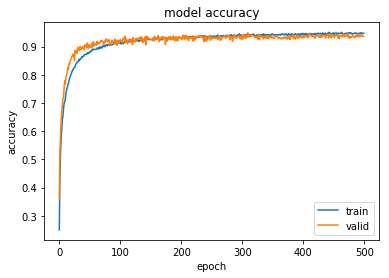

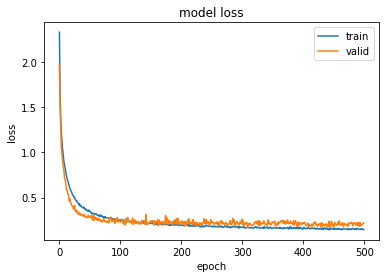

In [29]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()